In [26]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [133]:
layer_names = ['dense', 'dense', 'dense', 'softmax']
hidden_units = [16, 8, 8, 10]
input_size = 784
hidden_units.insert(0, input_size)

learning_rate = 0.001
keep_prob = 0.2

In [113]:
class Dense:
    def __init__(self, units, input_size, activation, name):
        self.W = tf.Variable(tf.random.normal([units, input_size]) * tf.math.sqrt(1/input_size), name=(name + '_W'))
        self.b = tf.Variable(tf.zeros([units,1]), name=(name + '_b'))
        self.activation = activation

    def forward(self, X, training):
        Z = tf.linalg.matmul(self.W,X) + self.b
        A = self.activation(Z)
        return A

    def get_vars(self):
        return [self.W, self.b]

In [114]:
class Batch_norm:
    def __init__(self, units, input_size, activation, name):
        self.W = tf.Variable(tf.random.normal([units, input_size]) * tf.math.sqrt(1/input_size), name=(name + '_W')) 
        self.activation = activation

        self.gamma = tf.Variable(tf.ones([units, 1]), name=(name + '_gamma'))
        self.beta = tf.Variable(tf.ones([units, 1]), name=(name + '_beta'))
        self.mu_test = 0
        self.sigma_test = 1

    def forward(self, X, training):
        e = 10**-8

        Z = tf.linalg.matmul(self.W,X)

        if training:
            mu = tf.math.reduce_mean(Z, axis=1, keepdims=True)
            sigma = tf.math.reduce_variance(Z - mu, axis=1, keepdims=True)
            sigma = tf.math.sqrt(sigma + e)
            
            self.mu_test = 0.95*self.mu_test + 0.05*mu
            self.sigma_test = 0.95*self.sigma_test + 0.05*sigma
        else:
            mu = self.mu_test
            sigma = self.sigma_test

        Z = (Z - mu) / sigma
        Z = self.gamma * Z + self.beta

        A = self.activation(Z)
        return A

    def get_vars(self):
        return [self.W, self.gamma, self.beta]

In [115]:
class Dropout:
    def __init__(self, keep_prob):
        self.keep_prob = keep_prob

    def forward(self, X, training):
        if not training:
            return X

        D = tf.random.uniform([]) < self.keep_prob
        D = tf.cast(D, dtype=tf.float32)
        X = X * D
        X = X / keep_prob
        return X

    def get_vars(self):
        return None

In [118]:
class Softmax:
    def __init__(self, classes, input_size, name):
        self.classes = classes

        self.W = tf.Variable(tf.random.normal([classes, input_size]) * tf.math.sqrt(1/input_size), name=(name + '_W'))
        self.b = tf.Variable(tf.zeros([classes,1]), name=(name + '_b'))

    def forward(self, X, training):
        Z = tf.linalg.matmul(self.W,X) + self.b

        T = tf.math.exp(Z)
        A = T / tf.math.reduce_sum(T)
        return A

    def get_vars(self):
        return [self.W, self.b]

In [92]:
def Loss(A, Y):
    loss = tf.math.log(A)
    loss = A * Y
    loss = -tf.math.reduce_sum(loss)
    return loss

In [97]:
def Cost(A, Y):
    m = tf.shape(A)[1]
    m = tf.cast(m, tf.float32)
    losses = Loss(A, Y)
    losses = tf.reduce_sum(losses)
    return losses / m

In [34]:
def forward_pass(X, layers, training):
    for layer in layers:
        X = layer.forward(X, training)
    return X

In [35]:
def get_vars(layers):
    var = []
    for layer in layers:
        x = layer.get_vars()
        if x != None:
            var += x
    return var

In [101]:
@tf.function
def training_step(X, Y, layers, learning_rate):
    with tf.GradientTape() as tape:
        var = get_vars(layers)
        tape.watch(var)
        A = forward_pass(X, layers, training=True)
        cost = Cost(A, Y)
    grads = tape.gradient(cost, var)
    for i in range(len(grads)):
        grad = -(grads[i] * learning_rate)
        var[i].assign_add(grad)
    return cost

In [37]:
def create_layers():
    layers = []
    i = 1
    for layer_name in layer_names:
        if layer_name == 'dense':
            layer = Dense(hidden_units[i], hidden_units[i-1], tf.nn.relu, 'Dense' + str(i+1))
            layers.append(layer)
            i += 1

        elif layer_name == 'batch_norm':
            layer = Batch_norm(hidden_units[i], hidden_units[i-1], tf.nn.relu, 'Batch_norm' + str(i+1))
            layers.append(layer)
            i += 1

        elif layer_name == 'dropout':
            layer = Dropout(keep_prob)
            layers.append(layer)

        elif layer_name == 'softmax':  
            layer = Softmax(hidden_units[i], hidden_units[i-1], 'Dense' + str(i+1))
            layers.append(layer)
            i += 1

    return layers

In [121]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train / 255
x_test = x_test / 255
y_train = tf.one_hot(y_train, depth=10, axis=0)
y_test = tf.one_hot(y_test, depth=10, axis=0)
x_train = x_train[:10000]
y_train = y_train[:,:10000]

x_train = tf.reshape(x_train, [784, -1])
x_train = tf.cast(x_train, tf.float32)

Epoch 1: -1.0024353287008125e-05
Epoch 11: -1.0024353287008125e-05
Epoch 21: -1.0024353287008125e-05
Epoch 31: -1.0024353287008125e-05
Epoch 41: -1.0024353287008125e-05
Epoch 51: -1.0024353287008125e-05
Epoch 61: -1.0024353287008125e-05
Epoch 71: -1.0024353287008125e-05
Epoch 81: -1.0024353287008125e-05
Epoch 91: -1.0024353287008125e-05
Epoch 101: -1.0024353287008125e-05
Epoch 111: -1.0024353287008125e-05
Epoch 121: -1.0024353287008125e-05
Epoch 131: -1.0024353287008125e-05
Epoch 141: -1.0024353287008125e-05
Epoch 151: -1.0024353287008125e-05
Epoch 161: -1.0024353287008125e-05
Epoch 171: -1.0024353287008125e-05
Epoch 181: -1.0024353287008125e-05
Epoch 191: -1.0024353287008125e-05
Epoch 201: -1.0024353287008125e-05
Epoch 211: -1.0024353287008125e-05
Epoch 221: -1.0024353287008125e-05
Epoch 231: -1.0024353287008125e-05
Epoch 241: -1.0024353287008125e-05
Epoch 251: -1.0024353287008125e-05
Epoch 261: -1.0024353287008125e-05
Epoch 271: -1.0024353287008125e-05
Epoch 281: -1.0024353287008125e

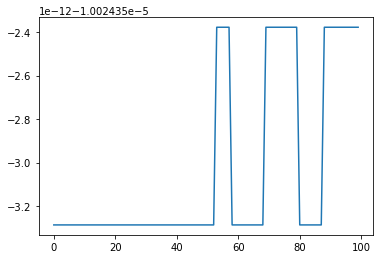

In [135]:
layers = create_layers()
costs = []

for i in range(1000):
    cost = training_step(x_train, y_train, layers, learning_rate)
    if i%10 == 0:
        costs.append(cost)
        print('Epoch {0}: {1}'.format(i+1, cost))

plt.plot(costs)
plt.show()